In [2]:
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
#from xbbg import blp # not necessary if you use hardcoded market data / proprietary API / non-BBG market data

In [ ]:
# AD specific

import jax.numpy as jnp
from jax import grad

In [ ]:
from cavour.utils import *
from cavour.trades.rates import *
from cavour.trades.rates.ois import OIS
from cavour.trades.rates.ois_curve import OISCurve
from cavour.market.curves.interpolator import *

In [5]:
value_dt = Date(30, 4, 2024)
value_dt_datetime = dt.date(2024, 4, 30)

## Build Model

In [6]:
# Extract data via BBG. #NOTE: you need to be logged into Bloomberg to run this cell

# tickers =["SONIO/N Index", "BPSWS1Z BGN Curncy","BPSWS2Z BGN Curncy",
#          "BPSWSA BGN Curncy","BPSWSB BGN Curncy","BPSWSC BGN Curncy","BPSWSD BGN Curncy","BPSWSE BGN Curncy",
#          "BPSWSF BGN Curncy","BPSWSG BGN Curncy","BPSWSH BGN Curncy","BPSWSI BGN Curncy","BPSWSJ BGN Curncy","BPSWSK BGN Curncy",
#          "BPSWS1 BGN Curncy","BPSWS1F BGN Curncy","BPSWS2 BGN Curncy","BPSWS3 BGN Curncy","BPSWS4 BGN Curncy","BPSWS5 BGN Curncy",
#          "BPSWS6 BGN Curncy","BPSWS7 BGN Curncy","BPSWS8 BGN Curncy","BPSWS9 BGN Curncy","BPSWS10 BGN Curncy","BPSWS12 BGN Curncy",
#          "BPSWS15 BGN Curncy","BPSWS20 BGN Curncy","BPSWS25 BGN Curncy","BPSWS30 BGN Curncy","BPSWS40 BGN Curncy","BPSWS50 BGN Curncy"]

# px_dict = {}
# px_list = []
# for ticker in tickers:
#     px = blp.bdh(ticker,"px_last",value_dt_datetime,value_dt_datetime)[ticker]['px_last'].iloc[0]
#     px_dict[ticker] = px
#     px_list.append(px)

In [7]:
# Hardcoded data for April 30th 2024. Uncomment to use / override BBG data

px_list = [5.1998,
 5.2014,
 5.2003,
 5.2027,
 5.2023,
 5.19281,
 5.1656,
 5.1482,
 5.1342,
 5.1173,
 5.1013,
 5.0862,
 5.0701,
 5.054,
 5.0394,
 4.8707,
 4.75483,
 4.532,
 4.3628,
 4.2428,
 4.16225,
 4.1132,
 4.08505,
 4.0762,
 4.078,
 4.0961,
 4.12195,
 4.1315,
 4.113,
 4.07724,
 3.984,
 3.88]

In [8]:
spot_days = 0
settle_dt = value_dt.add_weekdays(spot_days)

swaps = []
swap_type = SwapTypes.PAY
fixed_dcc_type = DayCountTypes.ACT_365F
fixed_freq_type = FrequencyTypes.ANNUAL
bus_day_type = BusDayAdjustTypes.MODIFIED_FOLLOWING
float_freq_type = FrequencyTypes.ANNUAL
float_dc_type = DayCountTypes.ACT_365F

tenor_list = ["1D","1W","2W","1M","2M","3M","4M","5M","6M","7M","8M","9M","10M","11M","1Y","18M","2Y","3Y","4Y","5Y","6Y","7Y","8Y","9Y","10Y","12Y","15Y","20Y","25Y","30Y","40Y","50Y"]

for tenor, px in zip(tenor_list, px_list):
    swap = OIS(effective_dt= settle_dt,
               term_dt_or_tenor= tenor,
               fixed_leg_type= swap_type,
               fixed_coupon= px / 100,
               fixed_freq_type= fixed_freq_type,
               fixed_dc_type=fixed_dcc_type,
               bd_type= bus_day_type,
               float_freq_type=float_freq_type,
               float_dc_type=float_dc_type
               )
    swaps.append(swap)


In [9]:
oisCurveObj = OISCurve(
    value_dt=value_dt, 
    ois_swaps= swaps, 
    interp_type= InterpTypes.LINEAR_ZERO_RATES,
    check_refit=False)

### Round Trip

In [10]:
# Round Trip 

round_trip = {}

for tenor, px in zip(tenor_list, px_list):
    swap = OIS(effective_dt= settle_dt,
               term_dt_or_tenor= tenor,
               fixed_leg_type= swap_type,
               fixed_coupon= px,
               fixed_freq_type= fixed_freq_type,
               fixed_dc_type=fixed_dcc_type,
               bd_type= bus_day_type,
               float_freq_type=float_freq_type,
               float_dc_type=float_dc_type
               )
    par_rate = swap.swap_rate(value_dt, oisCurveObj)*10000
    round_trip[tenor] = [px,par_rate,(par_rate-px)*100]

In [11]:
# Represent as Dataframe

# TODO understand why 10+ shows minor differences. HINT: Interpolation type for missing market quotes

round_trip_df = pd.DataFrame(round_trip).T
round_trip_df.columns = ["Market Rate","Par Rate","Difference in bps"]
round_trip_df.style.format({"Difference in bps": "{:.2f}"})
round_trip_df["Difference in bps"] = round_trip_df["Difference in bps"].round(2)
round_trip_df

,Market Rate,Par Rate,Difference in bps
1D,5.19980,5.199800,-0.00
1W,5.20140,5.201400,0.00
2W,5.20030,5.200300,0.00
1M,5.20270,5.202700,-0.00
2M,5.20230,5.202300,0.00
3M,5.19281,5.192810,0.00
4M,5.16560,5.165600,-0.00
5M,5.14820,5.148200,0.00
6M,5.13420,5.134200,0.00
7M,5.11730,5.117300,-0.00


In [12]:
# create Bumped model version at 10Y point

swaps = []

for tenor, px in zip(tenor_list, px_list):
    if tenor == "10Y":
        px += 0.01
    swap = OIS(effective_dt= settle_dt,
               term_dt_or_tenor= tenor,
               fixed_leg_type= swap_type,
               fixed_coupon= px / 100,
               fixed_freq_type= fixed_freq_type,
               fixed_dc_type=fixed_dcc_type,
               bd_type= bus_day_type,
               float_freq_type=float_freq_type,
               float_dc_type=float_dc_type
               )
    swaps.append(swap)

oisCurveObj_bump = OISCurve(
    value_dt=value_dt, 
    ois_swaps= swaps, 
    interp_type= InterpTypes.LINEAR_ZERO_RATES,
    check_refit=False)

## Extract Delta

In [13]:
px = 0.0407800
tenor = "10Y"

swap = OIS(effective_dt= settle_dt,
            term_dt_or_tenor= tenor,
            fixed_leg_type= swap_type,
            fixed_coupon= px,
            fixed_freq_type= fixed_freq_type,
            fixed_dc_type=fixed_dcc_type,
            bd_type= bus_day_type,
            float_freq_type=float_freq_type,
            float_dc_type=float_dc_type
            )
par_rate = swap.swap_rate(value_dt, oisCurveObj)*10000

swap.value(value_dt,oisCurveObj)

0.0

In [15]:
# Value swap with current model
swap.value(value_dt,oisCurveObj)

0.0

In [16]:
# PV01 using built-in bump() method
swap.pv01(value_dt,oisCurveObj_bump)

np.float64(803.5675315568802)

In [17]:
# PV01 using bumped model
swap.value(value_dt,oisCurveObj_bump)

803.5675315568224

#### Bloomberg PV01

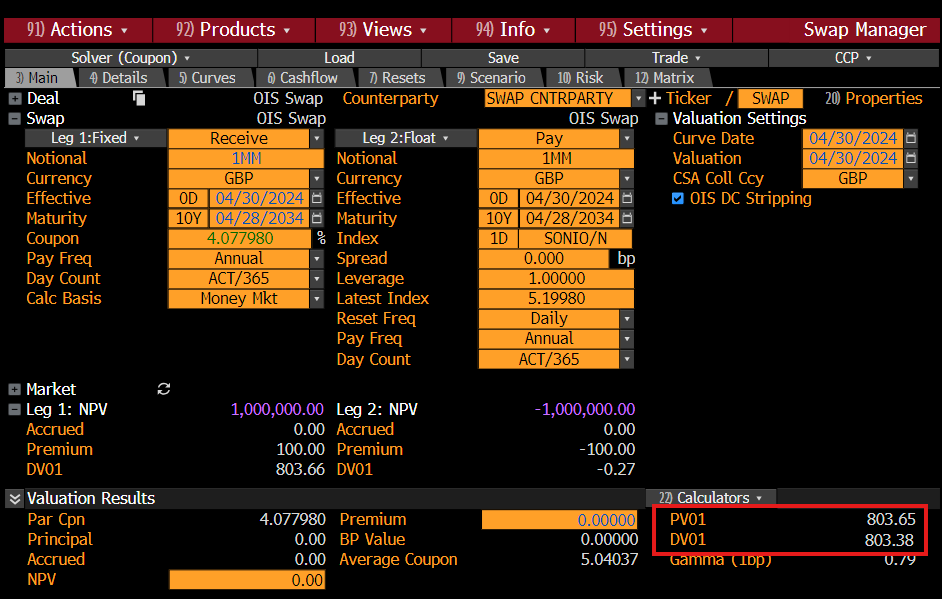

## Calculate DF Risk using Automatic Differetiation 

In [38]:
# Sensitiviy to 1bp change in DF

delta_df = swap.delta_ad(swap._fixed_leg._payment_dfs)
delta_df

Array([  -407.8    ,   -407.8    ,   -407.80063,   -406.6821 ,
         -410.03455,   -407.80124,   -407.79874,   -408.91602,
         -406.68335, -10406.683  ], dtype=float32)

## Check that automatic differentiation is correct

### Fixed Leg

In [40]:
# List of relevant discount factors
dfs_list = swap._fixed_leg._payment_dfs

In [51]:
# Lets bump the 1Y point
dfs_list_bumped = copy.deepcopy(dfs_list)
dfs_list_bumped[0] += 0.01

In [42]:
value_base_ad = swap._fixed_leg.value_ad(dfs_list)
value_bumped_ad = swap._fixed_leg.value_ad(dfs_list_bumped)
print(f"Base valuation is {value_base_ad}")
print(f"Bumped valuation is {value_bumped_ad}")

Base valuation is -327694.83936889574
Bumped valuation is -328102.6393688958


In [48]:
# Difference between base and bumped
value_bumped_ad - value_base_ad

-407.80000000004657

In [49]:
sensies_function = grad(swap._fixed_leg.value_ad)
delta_df_list = sensies_function(dfs_list)
delta_df_divided = jnp.array(delta_df_list) / 100 # Scale down to 1bp

In [50]:
# Expected Delta 
delta_df_divided[0]

Array(-407.8, dtype=float32)

Success! 